# Analyzing PBMCs of Covid patients and healthy controls

## Load libraries

In [177]:
import scanpy as sc
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

## Load the data

Make sure we are in the correct working directory

In [178]:
os.getcwd() #get current working directory

'C:\\Users\\bende\\Documents\\S3++_project\\DDD_disk'

In [179]:
# change working directory
os.chdir('C:\\Users\\bende\\Documents\\S3++_project\\DDD_disk')

In [180]:
# Load count matrices for all samples (cells by genes)
adata_cov1 = sc.read_10x_h5("data/nCoV_PBMC_1.h5")
adata_cov2 = sc.read_10x_h5("data/nCoV_PBMC_15.h5")
adata_cov3 = sc.read_10x_h5("data/nCoV_PBMC_17.h5")
adata_norm1 = sc.read_10x_h5("data/Normal_PBMC_13.h5")
adata_norm2 = sc.read_10x_h5("data/Normal_PBMC_14.h5")
adata_norm3 = sc.read_10x_h5("data/Normal_PBMC_5.h5")

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\readwrite.py:281: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\readwrite.py:281: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\anndat

In [181]:
sample_list = [adata_cov1, adata_cov2, adata_cov3, adata_norm1, adata_norm2, adata_norm3]

In [182]:
for i in sample_list:
    i.var_names_make_unique

In [183]:
adata_cov1.obs["sample"] = "cov1"
adata_cov2.obs["sample"] = "cov2"
adata_cov3.obs["sample"] = "cov3"
adata_norm1.obs["sample"] = "norm1"
adata_norm2.obs["sample"] = "norm2"
adata_norm3.obs["sample"] = "norm3"

In [184]:
adata_cov1.obs["condition"] = "covid"
adata_cov2.obs["condition"] = "covid"
adata_cov3.obs["condition"] = "covid"
adata_norm1.obs["condition"] = "control"
adata_norm2.obs["condition"] = "control"
adata_norm3.obs["condition"] = "control"

Concatenate all objects (combine adata objects into one)

## QC

### recording count depth, gene number and mitchondrial fraction

In [185]:
# Quality control - calculate QC covariates
for i in sample_list:
    i.obs['n_counts'] = i.X.sum(1)
    i.obs['log_counts'] = np.log(i.obs['n_counts'])
    i.obs['n_genes'] = (i.X > 0).sum(1)
    i.obs['log_genes'] = np.log(i.obs['n_genes'])

In [186]:
for i in sample_list:
    mt_gene_mask = [gene.startswith('MT-') for gene in i.var_names]
    i.X = i.X.toarray()
    i.obs['mt_frac'] = i.X[:, mt_gene_mask].sum(1)/i.obs['n_counts']

In [187]:
"""# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))"""

"# Filter cells according to identified QC thresholds:\nprint('Total number of cells: {:d}'.format(adata.n_obs))\n\nsc.pp.filter_cells(adata, min_counts = 1500)\nprint('Number of cells after min count filter: {:d}'.format(adata.n_obs))\n\nsc.pp.filter_cells(adata, max_counts = 40000)\nprint('Number of cells after max count filter: {:d}'.format(adata.n_obs))\n\nadata = adata[adata.obs['mt_frac'] < 0.2]\nprint('Number of cells after MT filter: {:d}'.format(adata.n_obs))\n\nsc.pp.filter_cells(adata, min_genes = 700)\nprint('Number of cells after gene filter: {:d}'.format(adata.n_obs))"

In [188]:
#sc.pp.filter_cells(adata, min_counts = np.median(adata.obs['n_counts']) - 3 * np.median(np.absolute(adata.obs['n_counts'] - np.median(adata.obs['n_counts']))))

In [189]:
np.median(adata_cov1.obs['n_counts'])

3337.0

In [190]:
np.median(np.absolute(adata_cov1.obs['n_counts'] - np.median(adata_cov1.obs['n_counts'])))

2463.0

In [191]:
def determine_threshold (adata, n = 3, mode = 'mad', min = True, max = True):
    if mode == 'mad':
        if min:
            min_threshold = np.median(adata.obs['log_counts']) - n * np.median(np.absolute(adata.obs['log_counts'] - np.median(adata.obs['log_counts'])))
        if max:
            max_threshold = np.median(adata.obs['log_counts']) + n * np.median(np.absolute(adata.obs['log_counts'] - np.median(adata.obs['log_counts'])))
        return min_threshold, max_threshold

In [192]:
for i in determine_threshold(adata_cov2, n = 2):
    print(i)

5.4027628898620605
9.788506031036377


C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

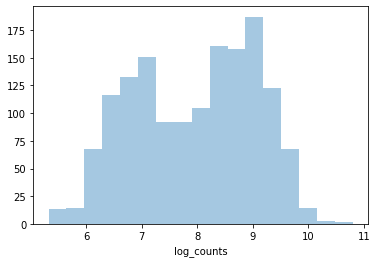

In [193]:
p6 = sb.distplot (adata_cov1.obs['log_counts'], kde = False)
plt.show

In [194]:
np.exp(5.32164192199707)

204.71974003555937

In [195]:
min(adata_cov1.obs['n_counts'])

205.0

In [196]:
np.exp(10.904012680053711)

54394.1929581709

In [197]:
sum(adata_cov3.obs['mt_frac'] < 0.2)

1295

In [202]:
def qc_count (adata, min = True, max = True, mt = False, max_mt_frac = None, n = 3):
    if min:
        min_value = determine_threshold(adata, n = n)[0]
        print(min_value)
        print(np.exp(min_value))
        adata = adata[adata.obs['log_counts'] > min_value, :]
        print (adata.shape)
    if max:
        max_value = determine_threshold(adata, n = n)[1]
        print(max_value)
        print(np.exp(max_value))
        adata = adata[adata.obs['log_counts'] < max_value, :]
        print (adata.shape)
    if mt:
        adata = adata[adata.obs['mt_frac'] < max_mt_frac, :]
        print (adata.shape)
    return adata

In [203]:
"""def qc_count2 (adata, min, max = None, mt = False, max_mt_frac = None, n = 3):
    if min:
        adata = adata[adata.obs['log_counts'] > min_value, :]
        print (adata.shape)
    if max:
        adata = adata[adata.obs['log_counts'] < max_value, :]
        print (adata.shape)
    if mt:
        adata = adata[adata.obs['mt_frac'] < max_mt_frac, :]
        print (adata.shape)
    return adata"""

"def qc_count2 (adata, min, max = None, mt = False, max_mt_frac = None, n = 3):\n    if min:\n        adata = adata[adata.obs['log_counts'] > min_value, :]\n        print (adata.shape)\n    if max:\n        adata = adata[adata.obs['log_counts'] < max_value, :]\n        print (adata.shape)\n    if mt:\n        adata = adata[adata.obs['mt_frac'] < max_mt_frac, :]\n        print (adata.shape)\n    return adata"

In [204]:
qc_count (adata_cov2, n=2,
          mt = True, max_mt_frac = 0.2)

5.4027628898620605
222.01898358534396
(1490, 33538)
9.7887544631958
17832.081815723563
(1370, 33538)
(961, 33538)


View of AnnData object with n_obs × n_vars = 961 × 33538
    obs: 'sample', 'condition', 'n_counts', 'log_counts', 'n_genes', 'log_genes', 'mt_frac'
    var: 'gene_ids', 'feature_types', 'genome'

In [205]:
"""qc_count2 (adata_cov2,
          determine_threshold(adata, n = 2)[0],
          determine_threshold(adata, n = 2)[1],
          mt = True, max_mt_frac = 0.2)"""

'qc_count2 (adata_cov2,\n          determine_threshold(adata, n = 2)[0],\n          determine_threshold(adata, n = 2)[1],\n          mt = True, max_mt_frac = 0.2)'